You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 1. Why are we here?

**Note: Future lessons have a lot more code than this one**

## Why study Numerical Linear Algebra?

**Key Question of this course**: How can we do matrix computations with acceptable speed and acceptable accuracy?

A list of the [Top 10 Algorithms](http://www.cs.fsu.edu/~lacher/courses/COT4401/notes/cise_v2_i1/index.html) of science and engineering during the 20th century includes: the **matrix decompositions** approach to linear algebra. It also includes the QR algorithm, which we'll cover, and Krylov iterative methods which we'll see an example of. (See here for [another take](https://nickhigham.wordpress.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics/))

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/top10.png?raw=1" alt="" style="width: 50%"/>
(source: [Top 10 Algorithms](http://www.cs.fsu.edu/~lacher/courses/COT4401/notes/cise_v2_i1/guest.pdf))

There are 4 things to keep in mind when choosing or designing an algorithm for matrix computations:
- Memory Use
- Speed
- Accuracy
- Scalability/Parallelization

Often there will be trade-offs between these categories.

### Motivation

Matrices are everywhere-- anything that can be put in an Excel spreadsheet is a matrix, and language and pictures can be represented as matrices as well.  Knowing what options there are for matrix algorithms, and how to navigate compromises, can make enormous differences to your solutions. For instance, an approximate matrix computation can often be thousands of times faster than an exact one.

It's not just about knowing the contents of existing libraries, but knowing how they work too. That's because often you can make variations to an algorithm that aren't supported by your library, giving you the performance or accuracy that you need. In addition, this field is moving very quickly at the moment, particularly in areas related to **deep learning**, **recommendation systems**, **approximate algorithms**, and **graph analytics**, so you'll often find there's recent results that could make big differences in your project, but aren't in your library.

Knowing how the algorithms really work helps to both debug and accelerate your solution.

## Matrix Computations

There are two key types of matrix computation, which get combined in many different ways. These are:
- Matrix and tensor products
- Matrix decompositions

So basically we're going to be combining matrices, and pulling them apart again!

### Matrix and Tensor Products

#### Matrix-Vector Products:

The matrix below gives the probabilities of moving from 1 health state to another in 1 year.  If the current health states for a group are:
- 85% asymptomatic
- 10% symptomatic
- 5% AIDS
- 0% death

what will be the % in each health state in 1 year?

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/markov_health.jpg?raw=1" alt="floating point" style="width: 80%"/>(Source: [Concepts of Markov Chains](https://www.youtube.com/watch?v=0Il-y_WLTo4))

#### Answer

In [1]:
import numpy as np

Notes:

* Rows are starting states (each row sums to 1)
* Columns are ending states

HIV Asym | HIV Sym

For example, row 1 reads like this:

| | HIV Asym | HIV Sym | AIDS | Death |
|:---|---:|---:|---:|---:|
| HIV Asym | 0.90 | 0.07 | 0.02 | 0.01 |
| HIV Sym | 0 | 0.93 | 0.05 | 0.02 |
| AIDS | 0 | 0 | 0.85 | 0.15 |
| Death | 0 | 0 | 0 | 1.00 |

which says that the edge between HIV Asym and itself is weighted as 0.90, or in human terms there's a 90% chance an individual is HIV asymptotic at time t, that they will continue to be HIV asymptotic at time t+1

Notice, if there is no edge between nodes it's encoded as a weight of 0



Step 1: model the markov chain as a linear combination, and thus a matrix multiplication

$$
\begin{aligned}
\begin{bmatrix}v^{asym}_{t+1},v^{sym}_{t+1},v^{AIDS}_{t+1},v^{Death}_{t+1}\end{bmatrix}
&=
\begin{bmatrix}v^{asym}_t,v^{sym}_t,v^{AIDS}_t,v^{Death}_t\end{bmatrix}
\times
\begin{bmatrix}
p^{asym \rightarrow asym}&p^{asym \rightarrow sym}&p^{asym \rightarrow AIDS}&p^{asym \rightarrow death}\\
p^{sym \rightarrow asym}&p^{sym \rightarrow sym}&p^{sym \rightarrow AIDS}&p^{sym \rightarrow death}\\
p^{AIDS \rightarrow asym}&p^{AIDS \rightarrow sym}&p^{AIDS \rightarrow AIDS}&p^{AIDS \rightarrow death}\\
p^{death \rightarrow asym}&p^{death \rightarrow sym}&p^{death \rightarrow AIDS}&p^{death \rightarrow death}\\
\end{bmatrix}
\\
&=
v^{asym}_t \begin{bmatrix} p^{asym \rightarrow asym}\\p^{sym \rightarrow asym}\\p^{AIDS \rightarrow asym}\\p^{death \rightarrow asym} \end{bmatrix}
+ v^{sym}_t \begin{bmatrix} p^{asym \rightarrow sym}\\p^{sym \rightarrow sym}\\p^{AIDS \rightarrow sym}\\p^{death \rightarrow sym} \end{bmatrix}
+ v^{AIDS}_t \begin{bmatrix} p^{asym \rightarrow AIDS}\\p^{sym \rightarrow AIDS}\\p^{AIDS \rightarrow AIDS}\\p^{death \rightarrow AIDS} \end{bmatrix}
+ v^{death}_t \begin{bmatrix} p^{asym \rightarrow death}\\p^{sym \rightarrow death}\\p^{AIDS \rightarrow death}\\p^{death \rightarrow death} \end{bmatrix}
\end{aligned}
$$

here' the matrices that can model these. We multiply the current population percentages at time `t` by their transition weights and get the new values at state `t+1`

Notice the shapes `1x4 * 4x4 = 1x4`

Since a vector by matrix multiplication is the same as a linear combination of the matrix's rows, it becomes clear that we are multiplying the value of the current state for each category by the transition weights for each

$$
\begin{aligned}
v^{asym}_{t+1} &=
v^{asym}_{t} \cdot p^{asym \rightarrow asym}
+ v^{sym}_{t} \cdot p^{sym \rightarrow asym}
+ v^{AIDS}_{t} \cdot p^{AIDS \rightarrow asym}
+ v^{death}_{t} \cdot p^{death \rightarrow asym}\\
&=0.85 \cdot 0.90 + 0.10 \cdot 0 + 0.05\cdot 0 + 0.00 \cdot 0 \\
&=0.765
\end{aligned}
$$

Therefore, 76.5% of people at state t+1 are HIV Asymptotic

In [32]:
#Exercise: Use Numpy to compute the answer to the above
"""
answer=
array([[ 0.765 ],
       [ 0.1525],
       [ 0.0645],
       [ 0.018 ]])
"""
weights = np.array([[0.9, 0.07, 0.02, 0.01],[0,0.93,0.05,0.02],[0,0,0.85,0.15],[0,0,0,1.00]])
print(weights)

"""
85% asymptomatic
10% symptomatic
5% AIDS
0% death
"""
states = []
states.append(np.array([0.85,0.10,0.05,0.00]).reshape(1,4))
print(states[0])



[[0.9  0.07 0.02 0.01]
 [0.   0.93 0.05 0.02]
 [0.   0.   0.85 0.15]
 [0.   0.   0.   1.  ]]
[[0.85 0.1  0.05 0.  ]]


In [33]:
states[0].reshape(1,4).transpose(-1, -2)

array([[0.85],
       [0.1 ],
       [0.05],
       [0.  ]])

In [46]:
states.append(
    states[0]@weights
)
print(states[-1])


[[0.765  0.1525 0.0645 0.018 ]]


For fun, lets see how this plays out for 10 rounds

In [79]:
from tabulate import tabulate


def infection_game(init_state: np.array, num_iterations: int) -> np.array:
  """returns the states of the game"""
  assert init_state.shape == (1,4)
  states = [init_state]
  weights = np.array([[0.9, 0.07, 0.02, 0.01],[0,0.93,0.05,0.02],[0,0,0.85,0.15],[0,0,0,1.00]])
  for i in range(num_iterations):
    states.append(states[i]@weights)
    print(f'iteration {i+1}:\n{tabulate(states[-1].T, tablefmt="fancy_grid")}')
  return np.vstack(states)
states = infection_game(np.array([0.85,0.10,0.05,0.00]).reshape(1,4), 100)

iteration 1:
╒════════╕
│ 0.765  │
├────────┤
│ 0.1525 │
├────────┤
│ 0.0645 │
├────────┤
│ 0.018  │
╘════════╛
iteration 2:
╒══════════╕
│ 0.6885   │
├──────────┤
│ 0.195375 │
├──────────┤
│ 0.07775  │
├──────────┤
│ 0.038375 │
╘══════════╛
iteration 3:
╒═══════════╕
│ 0.61965   │
├───────────┤
│ 0.229894  │
├───────────┤
│ 0.0896263 │
├───────────┤
│ 0.06083   │
╘═══════════╛
iteration 4:
╒═══════════╕
│ 0.557685  │
├───────────┤
│ 0.257177  │
├───────────┤
│ 0.10007   │
├───────────┤
│ 0.0850683 │
╘═══════════╛
iteration 5:
╒══════════╕
│ 0.501917 │
├──────────┤
│ 0.278212 │
├──────────┤
│ 0.109072 │
├──────────┤
│ 0.110799 │
╘══════════╛
iteration 6:
╒══════════╕
│ 0.451725 │
├──────────┤
│ 0.293872 │
├──────────┤
│ 0.11666  │
├──────────┤
│ 0.137743 │
╘══════════╛
iteration 7:
╒══════════╕
│ 0.406552 │
├──────────┤
│ 0.304921 │
├──────────┤
│ 0.122889 │
├──────────┤
│ 0.165637 │
╘══════════╛
iteration 8:
╒══════════╕
│ 0.365897 │
├──────────┤
│ 0.312035 │
├──────────┤
│ 0.127833 │

In [82]:
states, states.shape

(array([[8.50000000e-01, 1.00000000e-01, 5.00000000e-02, 0.00000000e+00],
        [7.65000000e-01, 1.52500000e-01, 6.45000000e-02, 1.80000000e-02],
        [6.88500000e-01, 1.95375000e-01, 7.77500000e-02, 3.83750000e-02],
        [6.19650000e-01, 2.29893750e-01, 8.96262500e-02, 6.08300000e-02],
        [5.57685000e-01, 2.57176688e-01, 1.00070000e-01, 8.50683125e-02],
        [5.01916500e-01, 2.78212269e-01, 1.09072034e-01, 1.10799196e-01],
        [4.51724850e-01, 2.93871566e-01, 1.16660173e-01, 1.37743412e-01],
        [4.06552365e-01, 3.04921295e-01, 1.22889222e-01, 1.65637118e-01],
        [3.65897129e-01, 3.12035470e-01, 1.27832951e-01, 1.94234450e-01],
        [3.29307416e-01, 3.15805786e-01, 1.31577724e-01, 2.23309074e-01],
        [2.96376674e-01, 3.16750900e-01, 1.34217503e-01, 2.52654922e-01],
        [2.66739007e-01, 3.15324705e-01, 1.35849956e-01, 2.82086332e-01],
        [2.40065106e-01, 3.11923706e-01, 1.36573478e-01, 3.11437710e-01],
        [2.16058595e-01, 3.06893604e-0

In [89]:
import plotly.graph_objects as go


x = np.arange(states.shape[0])
key_map = {
    0:"asymptomatic",
    1:"symptomatic",
    2:"AIDS",
    3:"death",
}
fig = go.Figure()
for i in range(states.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=states[:, i], mode="lines", name=f"{key_map[i]}"))
fig.update_layout(title="Infection Game: Effects of AIDS on a population over time",xaxis_title="Time", yaxis_title="Population Percentage", height=800)
fig.show()

#### Matrix-Matrix Products

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/shop.png?raw=1" alt="floating point" style="width: 100%"/>(Source: [Several Simple Real-world Applications of Linear Algebra Tools](https://www.mff.cuni.cz/veda/konference/wds/proc/pdf06/WDS06_106_m8_Ulrychova.pdf))

#### Answer

In [ ]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 50. ,  49. ],
       [ 58.5,  61. ],
       [ 43.5,  43.5]])

#### Image Data

Images can be represented by matrices.

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/digit.gif?raw=1" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


#### Convolution

*Convolutions* are the heart of convolutional neural networks (CNNs), a type of deep learning, responsible for the huge advances in image recognitionin the last few years.  They are now increasingly being used for speech as well, such as [Facebook AI's results](https://code.facebook.com/posts/1978007565818999/a-novel-approach-to-neural-machine-translation/) for speech translation which are 9x faster than RNNs (the current most popular approach for speech translation).

Computers are now more accurate than people at classifying images.

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/sportspredict.jpeg?raw=1" alt="ImageNet" style="width: 80%"/>
  (Source: [Andrej Karpathy](http://karpathy.github.io/2014/07/03/feature-learning-escapades/))

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/InsideImagenet.png?raw=1" alt="ImageNet" style="width: 80%"/>
  (Source: [Nvidia](https://blogs.nvidia.com/blog/2014/09/07/imagenet/))

You can think of a convolution as a special kind of matrix product

The 3 images below are all from an excellent blog post written by a fast.ai student on [CNNs from Different Viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c):

A convolution applies a filter to each section of an image:
<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/cnn1.png?raw=1" alt="CNNs" style="width: 40%"/>

Neural Network Viewpoint:
<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/cnn2.png?raw=1" alt="CNNs" style="width: 40%"/>

Matrix Multiplication Viewpoint:
<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/cnn3.png?raw=1" alt="CNNs" style="width: 80%"/>

Let's see how convolutions can be used for *edge detection* in [this notebook](convolution-intro.ipynb)(originally from the [fast.ai Deep Learning Course](http://course.fast.ai/))

### Matrix Decompositions

We will be talking about Matrix Decompositions every day of this course, and will cover the below examples in future lessons:

- **Topic Modeling** (NMF and SVD.  SVD uses QR)  A group of documents can be represented by a term-document matrix
<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/document_term.png?raw=1" alt="term-document matrix" style="width: 70%"/>
  (source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#))
<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/nmf_doc.png?raw=1" alt="NMF on documents" style="width: 70%"/>
  (source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

- **Background removal** (robust PCA, which uses truncated SVD)
![background removal](https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/surveillance3.png?raw=1)

- **Google's PageRank Algorithm** (eigen decomposition)

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/page_rank_graph.png?raw=1" alt="PageRank" style="width: 70%"/>
  (source: [What is in PageRank?](http://computationalculture.net/article/what_is_in_pagerank))

- List of other decompositions and some applications [matrix factorization jungle](https://sites.google.com/site/igorcarron2/matrixfactorizations)

## Accuracy

### Floating Point Arithmetic

To understand accuracy, we first need to look at **how** computers (which are finite and discrete) store numbers (which are infinite and continuous)

#### Exercise

Take a moment to look at the function $f$ below.  Before you try running it, write on paper what the output would be of $x_1 = f(\frac{1}{10})$.  Now, (still on paper) plug that back into $f$ and calculate $x_2 = f(x_1)$.  Keep going for 10 iterations.

This example is taken from page 107 of *Numerical Methods*, by Greenbaum and Chartier.

In [ ]:
def f(x):
    if x <= 1/2:
        return 2 * x
    if x > 1/2:
        return 2*x - 1

Only after you've written down what you think the answer should be, run the code below:

In [ ]:
x = 1/10
for i in range(80):
    print(x)
    x = f(x)

What went wrong?

#### Problem: math is continuous & infinite, but computers are discrete & finite

Two Limitations of computer representations of numbers:
1. they can't be arbitrarily large or small
2. there must be gaps between them

The reason we need to care about accuracy, is because computers can't store infinitely accurate numbers.  It's possible to create calculations that give very wrong answers (particularly when repeating an operation many times, since each operation could multiply the error).

How computers store numbers:

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/fpa.png?raw=1" alt="floating point" style="width: 60%"/>

The *mantissa* can also be referred to as the *significand*.

IEEE Double precision arithmetic:
- Numbers can be as large as $1.79 \times 10^{308}$ and as small as $2.23 \times 10^{-308}$.
- The interval $[1,2]$ is represented by discrete subset:
$$1, \: 1+2^{-52}, \: 1+2 \times 2^{-52},\: 1+3 \times 2^{-52},\: \ldots, 2$$

- The interval $[2,4]$ is represented:
$$2, \: 2+2^{-51}, \: 2+2 \times 2^{-51},\: 2+3 \times 2^{-51},\: \ldots, 4$$


Floats and doubles are not equidistant:

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/fltscale-wh.png?raw=1" alt="floating point" style="width: 100%"/>
Source: [What you never wanted to know about floating point but will be forced to find out](http://www.volkerschatz.com/science/float.html)

**Machine Epsilon**

Half the distance between 1 and the next larger number. This can vary by computer.  IEEE standards for double precision specify $$ \varepsilon_{machine} = 2^{-53} \approx 1.11 \times 10^{-16}$$

**Two important properties of Floating Point Arithmetic**:

- The difference between a real number $x$ and its closest floating point approximation $fl(x)$ is always smaller than $\varepsilon_{machine}$ in relative terms.  For some $\varepsilon$, where $\lvert \varepsilon \rvert \leq \varepsilon_{machine}$, $$fl(x)=x \cdot (1 + \varepsilon)$$

- Where * is any operation ($+, -, \times, \div$), and $\circledast$ is its floating point analogue,
    $$ x \circledast y = (x * y)(1 + \varepsilon)$$
for some $\varepsilon$, where $\lvert \varepsilon \rvert \leq \varepsilon_{machine}$
That is, every operation of floating point arithmetic is exact up to a relative error of size at most $\varepsilon_{machine}$

#### History

Floating point arithmetic may seem like a clear choice in hindsight, but there have been many, many ways of storing numbers:
- fixed-point arithmetic
- logarithmic and semilogarithmic number systems
- continued-fractions
- rational numbers
- possibly infinite strings of rational numbers
- level-index number systems
- fixed-slash and floating-slash number systems
- 2-adic numbers

For references, see [Chapter 1](https://perso.ens-lyon.fr/jean-michel.muller/chapitre1.pdf) (which is free) of the [Handbook of Floating-Point Arithmetic](http://www.springer.com/gp/book/9780817647049).  Yes, there is an entire 16 chapter book on floating point!

Timeline History of Floating Point Arithmetic:
- ~1600 BC: Babylonian radix-60 system was earliest floating-point system (Donald Knuth).  Represented the significand of a radix-60 floating-point representation (if ratio of two numbers is a power of 60, represented the same)
- 1630 Slide rule.  Manipulate only significands (radix-10)
- 1914 Leonardo Torres y Quevedo described an electromechanical implementation of Babbage's Analytical Engine with Floating Point Arithmetic.
- 1941 First real, modern implementation.  Konrad Zuse's Z3 computer.  Used radix-2, with 14 bit significand, 7 bit exponents, and 1 sign bit.
- 1985 IEEE 754-1985 Standard for Binary Floating-Point Arithmetic released.  Has increased accuracy, reliability, and portability.  [William Kahan](https://people.eecs.berkeley.edu/~wkahan/) played leading role.

"Many different ways of approximating real numbers on computers have been introduced.. And yet, floating-point arithmetic is **by far the most widely used** way of representing real numbers in modern computers. Simulating an infinite, continuous set (the real numbers) with a finite set (the “machine numbers”) is not a straightforward task: **clever compromises must be found between, speed, accuracy, dynamic range, ease of use and implementation, and memory**. It appears that floating-point arithmetic, with adequately chosen parameters (radix, precision, extremal exponents, etc.), is a very good compromise for most numerical applications."

Although a radix value of 2 (binary) seems like the pretty clear winner now for computers, a variety of other radix values have been used at various point:

- radix-8 used by early machines PDP-10, Burroughs 570 and 6700
- radix-16 IBM 360
- radix-10 financial calculations, pocket calculators, Maple
- radix-3 Russian SETUN computer (1958).  Benefits: minimizes beta x p (symbols x digits), for a fixed largest representable number beta^p - 1.  Rounding = truncation
- radix-2 most common.  Reasons: easy to implement.  Studies have shown (with implicit leading bit) this gives better worst-case or average accuracy than all other radices.

### Conditioning and Stability

Since we can not represent numbers exactly on a computer (due to the finiteness of our storage, and the gaps between numbers in floating point architecture), it becomes important to know *how small perturbations in the input to a problem impact the output*.

**"A stable algorithm gives nearly the right answer to nearly the right question."** --Trefethen

**Conditioning**: perturbation behavior of a mathematical problem (e.g. least squares)

**Stability**: perturbation behavior of an algorithm used to solve that problem on a computer (e.g. least squares algorithms, householder, back substitution, gaussian elimination)

Example: Eigenvalues of a Matrix

In [ ]:
import scipy.linalg as la

A = np.array([[1., 1000], [0, 1]])
B = np.array([[1, 1000], [0.001, 1]])

print(A)

print(B)

[[    1.  1000.]
 [    0.     1.]]
[[    1.     1000.   ]
 [    0.001     1.   ]]


In [ ]:
np.set_printoptions(suppress=True, precision=4)

In [ ]:
wA, vrA = la.eig(A)
wB, vrB = la.eig(B)

wA, wB

**Reminder: Two properties of Floating Point Arithmetic**

- The difference between a real number $x$ and its closest floating point approximation $fl(x)$ is always smaller than $\varepsilon_{machine}$ in relative terms.

- Every operation $+, -, \times, \div$ of floating point arithmetic is exact up to a relative error of size at most $\varepsilon_{machine}$

Examples we'll see:
- Classical vs Modified Gram-Schmidt accuracy
- Gram-Schmidt vs. Householder (2 different ways of computing QR factorization), how orthogonal the answer is
- Condition of a system of equations

### Approximation accuracy

It's rare that we need to do highly accurate matrix computations at scale. In fact, often we're doing some kind of machine learning, and less accurate approaches can prevent overfitting.

If we accept some decrease in accuracy, then we can often increase speed by orders of magnitude (and/or decrease memory use) by using approximate algorithms. These algorithms typically give a correct answer with some probability. By rerunning the algorithm multiple times you can generally increase that probability multiplicatively!

**Example**: A **bloom filter** allows searching for set membership with 1% false positives, using <10 bits per element. This often represents reductions in memory use of thousands of times.

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/bloom_filter.png?raw=1" alt="Bloom Filters" style="width: 60%"/>

The false positives can be easily handled by having a second (exact) stage check all returned items - for rare items this can be very effective. For instance, many web browsers use a bloom filter to create a set of blocked pages (e.g. pages with viruses), since blocked web pages are only a small fraction of the whole web. A false positive can be handled here by taking anything returned by the bloom filter and checking against a web service with the full exact list.  (See this [bloom filter tutorial](https://llimllib.github.io/bloomfilter-tutorial/) for more details).

### Expensive Errors

*The below examples are from Greenbaum & Chartier.*

European Space Agency spent 10 years and $7 billion on the Ariane 5 Rocket.

What can happen when you try to fit a 64 bit number into a 16 bit space (integer overflow):

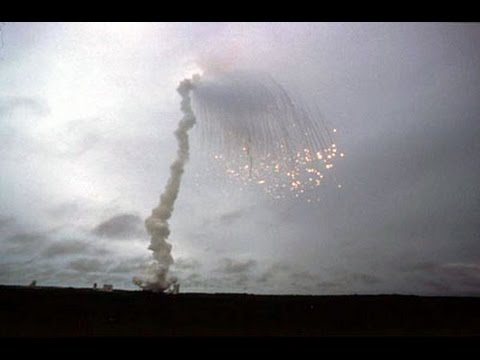

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("PK_yguLapgA")

Here is a floating point error that cost Intel $475 million:

[1994 NYTimes article about Intel Pentium Error](http://www.nytimes.com/1994/11/24/business/company-news-flaw-undermines-accuracy-of-pentium-chips.html)
![article](https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/pentium_nytimes.png?raw=1)

**Resources**: See Lecture 13 of Trefethen & Bau and Chapter 5 of Greenbaum & Chartier for more on Floating Point Arithmetic

## Memory Use

### Sparse vs Dense

Above we covered how *numbers* are stored, now let's talk about how *matrices* are stored. A key way to save memory (and computation) is not to store all of your matrix. Instead, just store the non-zero elements. This is called **sparse** storage, and it is well suited to sparse matrices, that is, matrices where most elements are zero.

<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/sparse.png?raw=1" alt="floating point" style="width: 50%"/>

Here is an example of the matrix from a finite element problem, which shows up in engineering (for instance, when modeling the air-flow around a plane). In this example, the non-zero elements are black and the zero elements are white:
<img src="https://github.com/aeged/numerical-linear-algebra/blob/master/nbs/images/Finite_element_sparse_matrix.png?raw=1" alt="floating point" style="width: 50%"/>
[Source](https://commons.wikimedia.org/w/index.php?curid=2245335)

There are also special types of structured matrix, such as diagonal, tri-diagonal, hessenberg, and triangular, which each display particular patterns of sparsity, which can be leveraged to reduce memory and computation.

The opposite of a sparse matrix is a **dense** matrix, along with dense storage, which simply refers to a matrix containing mostly non-zeros, in which every element is stored explicitly.  Since sparse matrices are helpful and common, numerical linear algebra focuses on maintaining sparsity through as many operations in a computation as possible.

## Speed

Speed differences come from a number of areas, particularly:
- Computational complexity
- Vectorization
- Scaling to multiple cores and nodes
- Locality

### Computational complexity

If you are unfamiliar with computational complexity and $\mathcal{O}$ notation, you can read about it [on Interview Cake](https://www.interviewcake.com/article/java/big-o-notation-time-and-space-complexity) and [practice on Codecademy](https://www.codecademy.com/courses/big-o/0/3). Algorithms are generally expressed in terms of computation complexity with respect to the number of rows and number of columns in the matrix. E.g. you may find an algorithm described as $\mathcal{O(n^2m)}$.

### Vectorization

Modern CPUs and GPUs can apply an operation to multiple elements at once on a single core. For instance, take the exponent of 4 floats in a vector in a single step. This is called SIMD. You will not be explicitly writing SIMD code (which tends to require assembly language or special C "intrinsics"), but instead will use vectorized operations in libraries like numpy, which in turn rely on specially tuned vectorized low level linear algebra APIs (in particular, BLAS, and LAPACK).

#### Matrix Computation Packages: BLAS and LAPACK

[BLAS (Basic Linear Algebra Subprograms)](http://www.netlib.org/blas/): specification for low-level matrix and vector arithmetic operations. These are the standard building blocks for performing basic vector and matrix operations.  BLAS originated as a Fortran library in 1979.  Examples of BLAS libraries include: AMD Core Math Library (ACML), ATLAS, Intel Math Kernel Library (MKL), and OpenBLAS.

[LAPACK](http://www.netlib.org/lapack/) is written in Fortran, provides routines for solving systems of linear equations, eigenvalue problems, and singular value problems.  Matrix factorizations (LU, Cholesky, QR, SVD, Schur).  Dense and banded matrices are handled, but not general sparse matrices.  Real and complex, single and double precision.

1970s and 1980s: EISPACK (eigenvalue routines) and LINPACK (linear equations and linear least-squares routines) libraries

**LAPACK original goal**: make LINAPCK and EISPACK run efficiently on shared-memory vector and parallel processors and exploit cache on modern cache-based architectures (initially released in 1992).  EISPACK and LINPACK ignore multi-layered memory hierarchies and spend too much time moving data around.

LAPACK uses highly optimized block operations implementations (which much be implemented on each machine) LAPACK written so as much of the computation as possible is performed by BLAS.

### Locality

Using slower ways to access data (e.g. over the internet) can be up to a billion times slower than faster ways (e.g. from a register). But there's much less fast storage than slow storage. So once we have data in fast storage, we want to do any computation required at that time, rather than having to load it multiple times each time we need it. In addition, for most types of storage its much faster to access data items that are stored next to each other, so we should try to always use any data stored nearby that we know we'll need soon. These two issues are known as locality.

#### Speed of different types of memory

Here are some *numbers everyone should know* (from the legendary [Jeff Dean](http://static.googleusercontent.com/media/research.google.com/en/us/people/jeff/stanford-295-talk.pdf)):
- L1 cache reference 0.5 ns
- L2 cache reference 7 ns
- Main memory reference/RAM 100 ns
- Send 2K bytes over 1 Gbps network 20,000 ns
- Read 1 MB sequentially from memory 250,000 ns
- Round trip within same datacenter 500,000 ns
- Disk seek 10,000,000 ns
- Read 1 MB sequentially from network 10,000,000 ns
- Read 1 MB sequentially from disk 30,000,000 ns
- Send packet CA->Netherlands->CA 150,000,000 ns

And here is an updated, interactive [version](https://people.eecs.berkeley.edu/~rcs/research/interactive_latency.html), which includes a timeline of how these numbers have changed.

**Key take-away**: Each successive memory type is (at least) an order of magnitude worse than the one before it.  Disk seeks are **very slow**.

This video has a great example of showing several ways you could compute the blur of a photo, with various trade-offs. Don't worry about the C code that appears, just focus on the red and green moving pictures of matrix computation.

Although the video is about a new language called Halide, it is a good illustration the issues it raises are universal.  Watch minutes 1-13:

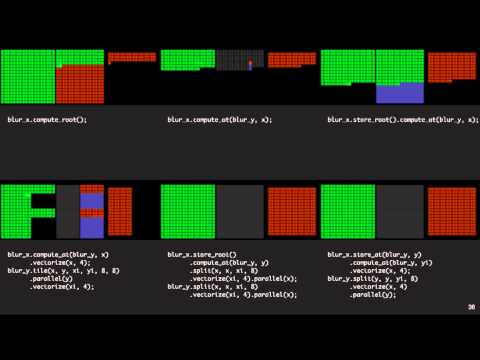

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("3uiEyEKji0M")

Locality is hard.  Potential trade-offs:
- redundant computation to save memory bandwidth
- sacrificing parallelism to get better reuse

#### Temporaries

The issue of "temporaries" occurs when the result of a calculation is stored in a temporary variable in RAM, and then that variable is loaded to do another calculation on it. This is many orders of magnitude slower than simply keeping the data in cache or registers and doing all necessary computations before storing the final result in RAM. This is particularly an issue for us since numpy generally creates temporaries for every single operation or function it does. E.g. $a=b\cdot c^2+ln(d)$ will create four temporaries (since there are four operations and functions).

### Scaling to multiple cores and nodes

We have a separate section for scalability, but it’s worth noting that this is also important for speed - if we can't scale across all the computing resources we have, we'll be stuck with slower computation.

## Scalability / parallelization

Often we'll find that we have more data than we have memory to handle, or time to compute. In such a case we would like to be able to scale our algorithm across [multiple cores](http://www.makeuseof.com/tag/processor-core-makeuseof-explains-2/) (within one computer) or nodes (i.e. multiple computers on a network). We will not be tackling multi-node scaling in this course, although we will look at scaling across multiple cores (called parallelization). In general, scalable algorithms are those where the input can be broken up into smaller pieces, each of which are handled by a different core/computer, and then are put back together at the end.